In [1]:
import tensorflow as tf
import keras
import cv2
import numpy as np
import shutil

Using TensorFlow backend.


In [2]:
print(tf.__version__)
print(keras.__version__)

1.3.0
2.2.4


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

Load the simulator image index first.

In [4]:
import pandas as pd
import os

In [5]:
TRAIN_DATA_PATH = os.path.join('..', 'data', 'tl_recorder_images', 'train')
VALID_DATA_PATH = os.path.join('..', 'data', 'tl_recorder_images', 'valid')
TRAIN_CSV_PATH = os.path.join(TRAIN_DATA_PATH, 'index.csv')
VALID_CSV_PATH = os.path.join(VALID_DATA_PATH, 'index.csv')
assert os.path.exists(TRAIN_CSV_PATH), 'File doesn\'t exist: {0}'.format(TRAIN_CSV_PATH)
assert os.path.exists(VALID_CSV_PATH), 'File doesn\'t exist: {0}'.format(VALID_CSV_PATH)

class_map = ['unknown', 'red', 'yellow', 'green']
columns = [
        'file', 'light_visible', 'light_state', 'light_distance',
        'car_pos_x', 'car_pos_y', 'car_pos_z', 
        'car_rot_x', 'car_rot_y', 'car_rot_z', 'car_rot_w',
        'light_pos_x', 'light_pos_y', 'light_pos_z', 
        'light_rot_x', 'light_rot_y', 'light_rot_z', 'light_rot_w'
    ]

df_train_original = pd.read_csv(TRAIN_CSV_PATH, sep=',', names=columns)
df_train_original.sample(n=10)

,file,light_visible,light_state,light_distance,car_pos_x,car_pos_y,car_pos_z,car_rot_x,car_rot_y,car_rot_z,car_rot_w,light_pos_x,light_pos_y,light_pos_z,light_rot_x,light_rot_y,light_rot_z,light_rot_w
5594,1549220246_31.jpg,1,2,44.176296,2122.129,1506.507,0.100896,0.0,0.0,0.664986,0.746856,2126.353,1550.636,5.576704,0.0,0.0,0.011119,0.999938
3389,1549220025_82.jpg,1,0,30.051347,1553.269,1162.594,0.117187,0.0,0.0,0.028545,0.999593,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.000000
7021,1549220389_02.jpg,1,0,27.833329,2173.080,1792.074,0.118050,0.0,0.0,0.681271,0.732032,2178.291,1819.328,5.576704,0.0,0.0,0.012154,0.999926
2061,1549219893_02.jpg,1,2,76.444102,1507.306,1164.377,0.027041,-0.0,0.0,0.031119,-0.999516,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.000000
5696,1549220256_5.jpg,1,1,37.553778,2122.916,1513.343,0.117906,0.0,0.0,0.664661,0.747145,2126.353,1550.636,5.576704,0.0,0.0,0.011119,0.999938
4380,1549220124_89.jpg,0,2,302.579339,2046.391,1260.770,0.015814,0.0,0.0,0.549403,0.835558,2126.353,1550.636,5.576704,0.0,0.0,0.011119,0.999938
3434,1549220030_32.jpg,1,0,44.180639,1539.550,1161.219,0.096318,0.0,0.0,0.141871,0.989885,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.000000
3191,1549220006_02.jpg,1,0,30.051347,1553.803,1162.665,0.117946,-0.0,0.0,0.044493,-0.999010,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.000000
6479,1549220334_81.jpg,1,0,79.928479,2163.816,1740.496,0.028385,0.0,0.0,0.672398,0.740190,2178.291,1819.328,5.576704,0.0,0.0,0.012154,0.999926
4503,1549220137_23.jpg,1,1,153.235415,2095.376,1400.392,0.023493,0.0,0.0,0.606181,0.795327,2126.353,1550.636,5.576704,0.0,0.0,0.011119,0.999938


In [6]:
df_valid_original = pd.read_csv(VALID_CSV_PATH, sep=',', names=columns)
df_valid_original.sample(n=10)

,file,light_visible,light_state,light_distance,car_pos_x,car_pos_y,car_pos_z,car_rot_x,car_rot_y,car_rot_z,car_rot_w,light_pos_x,light_pos_y,light_pos_z,light_rot_x,light_rot_y,light_rot_z,light_rot_w
550,1549224009_48.jpg,1,2,55.672736,1527.623,1161.788,0.053587,-0.0,0.0,0.070889,-0.997484,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.0
301,1549223984_58.jpg,1,1,27.401253,1556.413,1159.938,0.116866,-0.0,0.0,0.053125,-0.998588,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.0
511,1549224005_57.jpg,1,0,56.997311,1526.699,1161.936,0.051730,-0.0,0.0,0.047373,-0.998877,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.0
322,1549223986_66.jpg,1,1,30.925018,1552.844,1160.144,0.117520,-0.0,0.0,0.067959,-0.997688,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.0
642,1549224018_63.jpg,1,2,52.581695,1531.123,1161.494,0.065434,-0.0,0.0,0.028804,-0.999585,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.0
625,1549224016_94.jpg,1,2,52.581695,1530.436,1161.457,0.062598,-0.0,0.0,0.059339,-0.998238,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.0
755,1549224029_95.jpg,1,0,47.714287,1535.594,1161.022,0.086067,-0.0,0.0,0.026178,-0.999657,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.0
624,1549224016_86.jpg,1,2,52.581695,1530.377,1161.451,0.062406,-0.0,0.0,0.063859,-0.997959,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.0
332,1549223987_65.jpg,1,1,30.925018,1551.981,1160.219,0.118123,-0.0,0.0,0.094853,-0.995491,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.0
487,1549224003_16.jpg,1,0,56.997311,1526.762,1161.921,0.051794,-0.0,0.0,0.051450,-0.998676,1584.065,1156.953,5.576705,0.0,0.0,-0.000808,1.0


Create a derived dataframe that sets all lights to unknown if they are out of reach.
Apply a new encoding:

- `0`: unknown, none
- `1`: green
- `2`: yellow
- `3`: red

In [7]:
def one_hot(a):
    num_classes = 4
    a = np.atleast_1d(a)
    result = np.zeros(shape=(len(a), num_classes))
    result[np.arange(len(a)), a] = 1
    return result.squeeze().astype(int).tolist()

In [8]:
df_train = df_train_original.copy()
df_train.loc[df_train['light_visible'] == 0, 'light_state'] = -1
df_train['light_state'] += 1
df_train['light_state'] = df_train['light_state'].astype('category')
df_train['light_state_onehot'] = df_train['light_state'].astype(int).apply(one_hot)
df_train['light_state_name'] = df_train['light_state'].astype(int).apply(lambda x: class_map[x])
df_train.sample(n=10)

,file,light_visible,light_state,light_distance,car_pos_x,car_pos_y,car_pos_z,car_rot_x,car_rot_y,car_rot_z,car_rot_w,light_pos_x,light_pos_y,light_pos_z,light_rot_x,light_rot_y,light_rot_z,light_rot_w,light_state_onehot,light_state_name
5390,1549220225_92.jpg,1,1,57.871421,2120.5450,1492.330,0.050151,0.0,0.0,0.669308,0.742985,2126.3530,1550.636,5.576704,0.0,0.0,0.011119,0.999938,"[0, 1, 0, 0]",red
530,1549219700_92.jpg,1,3,25.192985,162.2479,2304.942,0.151779,-0.0,0.0,0.744700,-0.667400,160.8088,2279.929,5.606704,0.0,0.0,-0.016577,0.999863,"[0, 0, 0, 1]",green
5539,1549220240_81.jpg,1,3,47.717893,2121.7260,1502.946,0.081519,0.0,0.0,0.665598,0.746310,2126.3530,1550.636,5.576704,0.0,0.0,0.011119,0.999938,"[0, 0, 0, 1]",green
1103,1549219758_21.jpg,0,0,265.604388,255.3078,1796.319,0.051702,-0.0,0.0,0.544255,-0.838920,363.3780,1553.731,5.606708,0.0,0.0,-0.010369,0.999946,"[1, 0, 0, 0]",unknown
4859,1549220172_8.jpg,1,3,81.284791,2110.5310,1470.621,0.027804,0.0,0.0,0.652094,0.758138,2126.3530,1550.636,5.576704,0.0,0.0,0.011119,0.999938,"[0, 0, 0, 1]",green
6572,1549220344_13.jpg,1,1,66.678781,2166.4170,1753.647,0.034830,0.0,0.0,0.663427,0.748241,2178.2910,1819.328,5.576704,0.0,0.0,0.012154,0.999926,"[0, 1, 0, 0]",red
717,1549219719_6.jpg,0,0,665.875329,156.0789,2178.261,0.052605,-0.0,0.0,0.716015,-0.698085,363.3780,1553.731,5.606708,0.0,0.0,-0.010369,0.999946,"[1, 0, 0, 0]",unknown
848,1549219732_7.jpg,0,0,535.565432,162.6370,2047.929,0.023153,-0.0,0.0,0.640189,-0.768217,363.3780,1553.731,5.606708,0.0,0.0,-0.010369,0.999946,"[1, 0, 0, 0]",unknown
6651,1549220352_03.jpg,1,1,56.083812,2168.1920,1763.393,0.054264,0.0,0.0,0.635400,0.772183,2178.2910,1819.328,5.576704,0.0,0.0,0.012154,0.999926,"[0, 1, 0, 0]",red
6578,1549220344_74.jpg,1,1,66.243121,2166.5620,1754.266,0.035514,0.0,0.0,0.645738,0.763559,2178.2910,1819.328,5.576704,0.0,0.0,0.012154,0.999926,"[0, 1, 0, 0]",red


In [9]:
df_valid = df_valid_original.copy()
df_valid.loc[df_valid['light_visible'] == 0, 'light_state'] = -1
df_valid['light_state'] += 1
df_valid['light_state'] = df_valid['light_state'].astype('category')
df_valid['light_state_onehot'] = df_valid['light_state'].astype(int).apply(one_hot)
df_valid['light_state_name'] = df_valid['light_state'].astype(int).apply(lambda x: class_map[x])

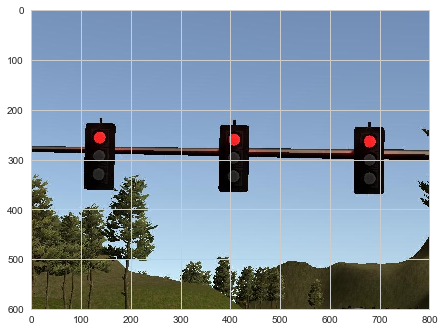

In [10]:
row = df_valid.iloc[0]
im_test = cv2.imread(os.path.join(VALID_DATA_PATH, row.light_state_name, row.file))
im_test = cv2.cvtColor(im_test, cv2.COLOR_BGR2RGB)
plt.imshow(im_test);

For Keras dataflows to work without trouble, we need to push the images to subdirectories first.

In [11]:
def fix_subdirs(df, base_dir):
    categories = df['light_state'].cat.categories.values
    for c in categories:
        class_name = class_map[c]
        path = os.path.join(base_dir, class_name)
        if not os.path.exists(path):
            os.mkdir(path)
    for i, row in df.iterrows():
        class_name = class_map[row.light_state]
        source_path = os.path.join(base_dir, row.file)
        target_path = os.path.join(base_dir, class_name, row.file)
        if os.path.exists(source_path):
            print('move ' + source_path + ' to ' + target_path)
            shutil.move(source_path, target_path)

fix_subdirs(df_train, TRAIN_DATA_PATH)
fix_subdirs(df_valid, VALID_DATA_PATH)

Next, we obtain the base model to use.

In [30]:
from keras.applications.mobilenetv2 import MobileNetV2, preprocess_input
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [13]:
#graph = tf.Graph().as_default()

In [21]:
input_tensor = Input(shape=(128, 128, 3))
base_model = MobileNetV2(input_shape=(128, 128, 3), alpha=1.0,
                         include_top=False, weights='imagenet', 
                         input_tensor=input_tensor)

From here, we can define a custom classifier to build on top of the base model.

In [22]:
# https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975

for layer in base_model.layers:
    layer.trainable = True

op = Flatten(input_shape=base_model.output_shape[1:])(base_model.output)
op = Dense(256, activation='relu')(op)
op = Dropout(0.5)(op)
op = Dense(4)(op)
op = Activation(tf.nn.softmax)(op)

model = Model(inputs=input_tensor, outputs=op)

In [33]:
epochs = 10
batch_size = 16
steps_per_epoch_train_samples = len(df_train) / batch_size
steps_per_epoch_valid_samples = len(df_valid) / batch_size

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['categorical_accuracy'])

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    height_shift_range=[-32, 32],
    rotation_range=20)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator=train_datagen.flow_from_directory(
    directory=TRAIN_DATA_PATH, 
    #dataframe=df_train, 
    #x_col='file', y_col='light_state_name',
    #class_mode='categorical', 
    classes=class_map,
    target_size=(128, 128), batch_size=32)

valid_generator=test_datagen.flow_from_directory(
    directory=VALID_DATA_PATH,
    #dataframe=df_valid, 
    #x_col='file', y_col='light_state_name', 
    #class_mode='categorical',
    classes=class_map,
    target_size=(128, 128), batch_size=32)

checkpoint = ModelCheckpoint('model-{epoch:03d}.h5', verbose=1, 
                             monitor='val_loss', save_best_only=True, mode='auto')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5,
                           verbose=1, mode='auto', baseline=None, restore_best_weights=True)

# fine-tune the model
model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_train_samples,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=steps_per_epoch_valid_samples, 
    callbacks=[checkpoint, early_stop], 
    verbose=True)

Found 7152 images belonging to 4 classes.
Found 784 images belonging to 4 classes.
Epoch 1/10
447/447 [==============================] - 83s 185ms/step - loss: 0.2305 - categorical_accuracy: 0.9180 - val_loss: 1.1320 - val_categorical_accuracy: 0.9214

Epoch 00001: val_loss improved from inf to 1.13196, saving model to model-001.h5
Epoch 2/10
447/447 [==============================] - 80s 180ms/step - loss: 0.1972 - categorical_accuracy: 0.9294 - val_loss: 0.8899 - val_categorical_accuracy: 0.9134

Epoch 00002: val_loss improved from 1.13196 to 0.88988, saving model to model-002.h5
Epoch 3/10
447/447 [==============================] - 81s 182ms/step - loss: 0.1957 - categorical_accuracy: 0.9319 - val_loss: 2.7444 - val_categorical_accuracy: 0.8210

Epoch 00003: val_loss did not improve from 0.88988
Epoch 4/10
447/447 [==============================] - 81s 182ms/step - loss: 0.1575 - categorical_accuracy: 0.9454 - val_loss: 0.5207 - val_categorical_accuracy: 0.9518

Epoch 00004: val_los

In [34]:
model.save('final.h5')